Data Cleaning & Pre-processing

In [2]:
# 1.Importing all the required libraries/ modules

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")


Load Raw Data: Read the collected data into pandas DataFrames.

Clean Data:
    Handle missing values using methods like imputation or removal (df.fillna(), df.dropna()).
    Correct data types (df.astype()).
    Remove duplicates (df.drop_duplicates())
    
Aggregate traffic data:
    Compile traffic data into hourly intervals for each junction.
    Ensure data includes relevant details such as vehicle counts.
    
Preprocess the data: Normalize or standardize the data to facilitate comparison across different time periods and junctions.

In [4]:
# Load Dataset
df = pd.read_csv("Dataset_Uber Traffic.csv")

In [5]:
# Initial inspection of the given dataset
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  48120 non-null  object
 1   Junction  48120 non-null  int64 
 2   Vehicles  48120 non-null  int64 
 3   ID        48120 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


,DateTime,Junction,Vehicles,ID
0,01/11/15 0:00,1,15,20151101001
1,01/11/15 1:00,1,13,20151101011
2,01/11/15 2:00,1,10,20151101021
3,01/11/15 3:00,1,7,20151101031
4,01/11/15 4:00,1,9,20151101041


In [6]:
#Checking for duplicate rows
duplicates = df.duplicated()
print(f'Number of duplicate rows: {duplicates.sum()}')

Number of duplicate rows: 0


In [7]:
# Handling missing values & replacing duplicates into the given dataset
df = df.dropna()
df = df.drop_duplicates()

In [8]:
# Type conversion i.e. Converting "DateTime" to datetime object type
df['DateTime'] = pd.to_datetime(df['DateTime'])

In [9]:
# Handling outliers using IQR method

# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df['Vehicles'].quantile(0.25)
Q3 = df['Vehicles'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
outliers = df[(df['Vehicles'] < lower_bound) | (df['Vehicles'] > upper_bound)]
print(f'Number of outliers: {outliers.shape[0]}')

Number of outliers: 3617


In [10]:
# Filter in-place
df = df[(df['Vehicles'] >= lower_bound) & (df['Vehicles'] <= upper_bound)]
print(f'New df size: {df.shape[0]}')

New df size: 44503


In [11]:
#Removing Outliers
df_clean = df[(df['Vehicles'] >= lower_bound) & (df['Vehicles'] <= upper_bound)]

In [12]:
# Cross checking if the outliers are removed
print(f'Original data size: {df.shape[0]}')
print(f'Cleaned data size: {df_clean.shape[0]}')

Original data size: 44503
Cleaned data size: 44503


In [13]:
# Checking the range of dates
print(f'Start Date: {df["DateTime"].min()}')
print(f'End Date: {df["DateTime"].max()}')

# Check for consistency in 'Junction' and 'ID' columns
print(df['Junction'].unique())
print(df['ID'].unique())

Start Date: 2015-01-11 00:00:00
End Date: 2017-12-06 23:00:00
[1 2 3 4]
[20151101001 20151101011 20151101021 ... 20170630214 20170630224
 20170630234]


Aggregating traffic data
Compile traffic data into hourly intervals for each junction.
Ensure data includes relevant details such as vehicle counts.

In [15]:
# Seting 'DateTime' as the index for resampling
df.set_index('DateTime', inplace=True)

# Resampling the data to hourly intervals and aggregate vehicle counts
df_hourly = df.groupby('Junction').resample('H').agg({'Vehicles': 'sum'}).reset_index()

# Check the first few rows of the aggregated data
print(df_hourly.head())

   Junction            DateTime  Vehicles
0         1 2015-01-11 00:00:00        15
1         1 2015-01-11 01:00:00        13
2         1 2015-01-11 02:00:00        10
3         1 2015-01-11 03:00:00         7
4         1 2015-01-11 04:00:00         9


In [16]:
# Checking & verify if there are any missing hours and data for a specific junction
missing_hours = df_hourly[df_hourly['Vehicles'].isna()]
print(f'Missing hours: {missing_hours.shape[0]}')

Missing hours: 0


In [17]:
# Checking the data for a specific junction
junction_id = 3  # Change this to the junction of interest
df_junction_hourly = df_hourly[df_hourly['Junction'] == junction_id]
print(df_junction_hourly.head())

       Junction            DateTime  Vehicles
50913         3 2015-01-11 00:00:00         9
50914         3 2015-01-11 01:00:00         7
50915         3 2015-01-11 02:00:00         5
50916         3 2015-01-11 03:00:00         1
50917         3 2015-01-11 04:00:00         2


Finally, Data is processed for comparisons accross different timeperiods and junctions as required in the project.

Feature Engineering & Selection:

1. Create new features from raw data:

    Generate time-based features such as hour of the day, day of the week, and month.

    Develop lag features by including traffic data from previous hours or days to capture temporal dependencies.

    Create binary indicators for weekends and special events to account for their impact on traffic.

2. Evaluate feature importance:
    Use statistical methods and machine learning techniques (e.g., correlation analysis, feature importance from tree-based models) to assess the   relevance of each feature.
    
    Select the most influential features for model training to improve efficiency and performance.

In [21]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
# Extract time-based features
df_hourly['HourOfDay'] = df_hourly['DateTime'].dt.hour
df_hourly['DayOfWeek'] = df_hourly['DateTime'].dt.dayofweek
df_hourly['Month'] = df_hourly['DateTime'].dt.month

# Lag features
df_hourly['PrevHourVehicles'] = df_hourly['Vehicles'].shift(1)
df_hourly['PrevDayVehicles'] = df_hourly['Vehicles'].shift(24)  # assuming hourly data

# Binary indicators
df_hourly['IsWeekend'] = df_hourly['DateTime'].dt.dayofweek >= 5

# Drop rows with NaN values generated by lag features
df_hourly.dropna(inplace=True)

# Feature and target columns
features = ['HourOfDay', 'DayOfWeek', 'Month', 'PrevHourVehicles', 'PrevDayVehicles', 'IsWeekend']
target = 'Vehicles'

X = df_hourly[features]
y = df_hourly[target]


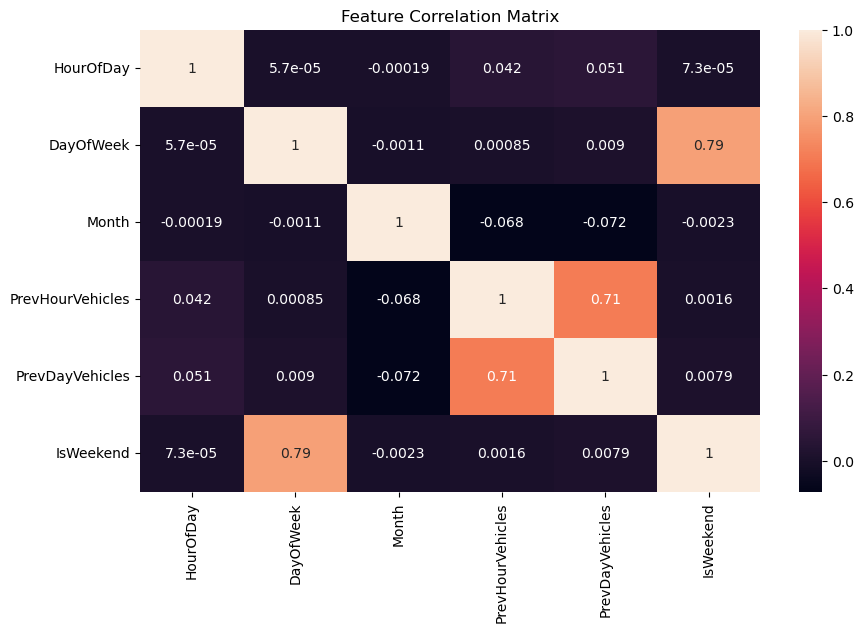

In [22]:
# Correlation analysis
plt.figure(figsize=(10, 6))
sns.heatmap(df_hourly[['HourOfDay', 'DayOfWeek', 'Month', 'PrevHourVehicles', 'PrevDayVehicles', 'IsWeekend']].corr(), annot=True)
plt.title("Feature Correlation Matrix")
plt.show()

Evaluation:

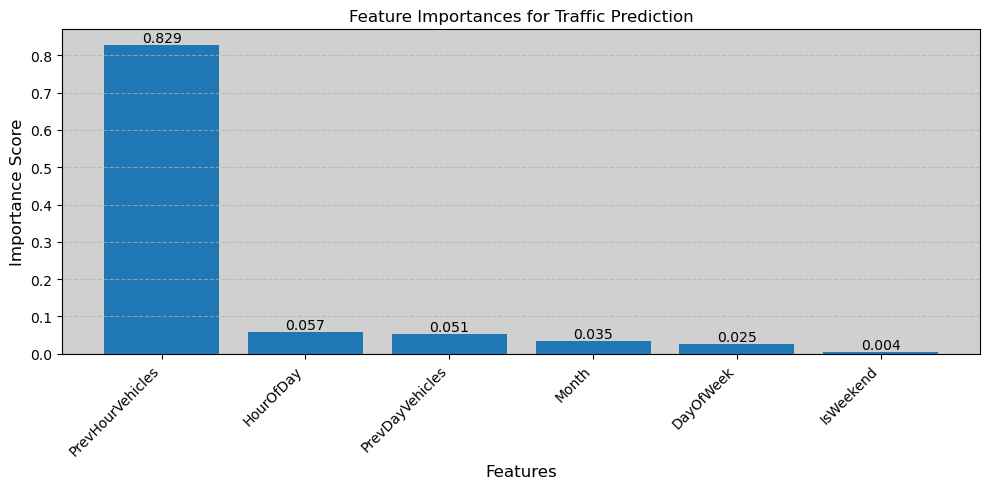


Feature Importance Scores:

            Feature  Importance
3  PrevHourVehicles    0.828604
0         HourOfDay    0.057144
4   PrevDayVehicles    0.051357
2             Month    0.034806
1         DayOfWeek    0.024577
5         IsWeekend    0.003512


In [59]:

# Evaluate feature importance using a RandomForest model
model = RandomForestRegressor()
model.fit(X, y)

# Feature importance
feature_importances = model.feature_importances_
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)


# Plot importance
plt.figure(figsize=(10, 5))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.title('Feature Importances for Traffic Prediction')
plt.xlabel('Features', fontsize = 12)
plt.ylabel('Importance Score', fontsize = 12)
plt.xticks(rotation=45, ha='right', fontsize=10)  # Adjusted font size for x-axis labels
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Added grid lines 
plt.tight_layout()
for i, v in enumerate(importance_df['Importance']):
    plt.text(i, v, f'{v:.3f}', ha='center', va='bottom')
plt.gca().set_facecolor('#d0d0d0')
plt.show()
print("\nFeature Importance Scores:\n")

# Display feature importance
print(importance_df)

So the exploratory data analysis is done & completed.